In [1]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 55.1 MB/s eta 0:00:00


In [2]:
! pip install torch_lr_finder

In [3]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=c4d3357b06375e8cd3bba9d54c85292a9ce602773b18bd7f0e9656d6193380ca
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [4]:
!pip install torchsummary

In [5]:
# imports
import os
import torch
from pytorch_lightning import LightningModule, Trainer,seed_everything
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy
from torchvision import datasets,transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR
import torch.optim as optim
from torch_lr_finder import LRFinder
from torchsummary import summary
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

seed_everything(5)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

INFO:lightning_fabric.utilities.seed:Global seed set to 5


Getting Dataset

In [6]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

train_transforms = A.Compose([
                    A.Normalize (mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
                    A.PadIfNeeded(min_height=40, min_width=40, always_apply=True,p=0.5),
                    A.RandomCrop(height=32, width=32, always_apply=True,p=0.5,),
                    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, fill_value=0, mask_fill_value=None, always_apply=False, p=0.2),
                    ToTensorV2()])
test_transforms= A.Compose([
                             A.Normalize (mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
                             ToTensorV2() ])


Model Definition

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])


Lightning Module

In [8]:
class LitCFAR(LightningModule):
    def __init__(self,lr=0.01):
      super().__init__()
      self.model=ResNet18()
      self.save_hyperparameters()

    def forward(self, x):
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        criterion=nn.CrossEntropyLoss()
        loss = criterion(pred, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
        self.parameters(),
        lr=self.hparams.lr,
        weight_decay=5e-4,
        )
        steps_per_epoch = 50000 // BATCH_SIZE +1
        scheduler_dict = {
        "scheduler": OneCycleLR(
            optimizer,
            max_lr=1.80E-02,
            pct_start=5/self.trainer.max_epochs,
            epochs=self.trainer.max_epochs,
            steps_per_epoch=steps_per_epoch,
            div_factor=100,
            three_phase=False,
            final_div_factor=100,
            anneal_strategy='linear'
        ),
        "interval": "step",
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}


    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y,task="multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")


In [9]:
train_data = Cifar10SearchDataset(root='./data', train=True,download=True, transform=train_transforms)
test_data = Cifar10SearchDataset(root='./data', train=False,download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=512,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=512,shuffle=True)

renet=LitCFAR()


trainer = Trainer(
    max_epochs=20,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(renet, train_dataloaders=train_loader,val_dataloaders=test_loader)
#trainer.test(model, datamodule=test_loader)

100%|██████████| 170498071/170498071 [00:13<00:00, 12909746.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


,lr-Adam,train_loss,val_loss,val_acc
epoch,,,,
NaN,0.001966,NaN,NaN,NaN
0.0,NaN,1.373757,NaN,NaN
0.0,NaN,NaN,1.583524,0.4561
NaN,0.003788,NaN,NaN,NaN
1.0,NaN,1.126759,NaN,NaN


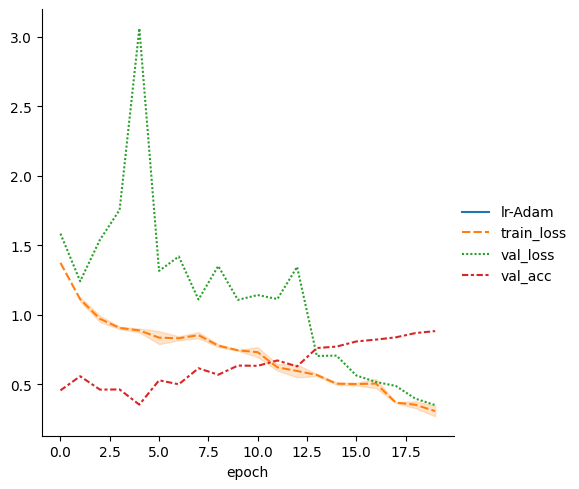

In [10]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [11]:
torch.save(renet.state_dict(), '/content/sample_data/model.pth')

Misclassified Images

In [11]:
test_data = Cifar10SearchDataset(root='./data', train=False,download=True, transform=test_transforms)

inv_map = {v: k for k, v in test_data.class_to_idx.items()}

Files already downloaded and verified


In [12]:
model1=ResNet18()
model1.load_state_dict(torch.load("/content/sample_data/model.pth",map_location=torch.device('cpu')),strict=False)
#model.load_state_dict(torch.load("/content/model.pth"))

_IncompatibleKeys(missing_keys=['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.bn2.running_mean', 'layer2.0.bn2.running_var', 'layer2.0.shortcut.0.weight', 'layer2.0.shortcut.1.weight', 'layer2.0.shortcut.1.bias', 'layer2.0.shortcut.1.running_mean', 'layer2

In [29]:

def misclassified_image(data_loader,model,inv_map):

  image,label=next(iter(test_loader))
  image, label = image.cuda(), label.cuda()
  output = model(image)
  pred = output.argmax(dim=1, keepdim=True)

  correct_image=[]
  misclassified_image=[]
  correct_label=[]
  actual_label=[]
  incorrect_label=[]
  misclassified_image=[]
  for img in range (len(label)):
    if pred[img].item()==label[img].item():
      correct_image.append(image[img])
      correct_label.append(inv_map[label[img].item()])
    else:
      misclassified_image.append(image[img])
      actual_label.append(inv_map[label[img].item()])
      incorrect_label.append(inv_map[pred[img].item()])
  return misclassified_image,actual_label,incorrect_label

In [30]:
inv_map = {v: k for k, v in test_data.class_to_idx.items()}
misclassified_image,actual_label,incorrect_label = misclassified_image(test_loader,model1,inv_map)

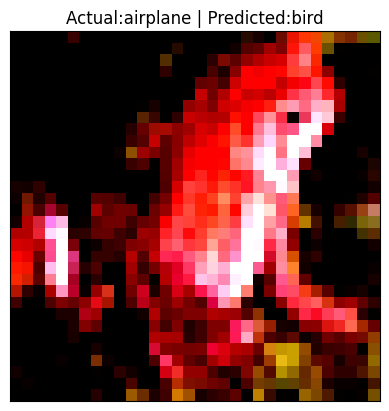

In [16]:
# Number of Images to download
n=15
#for i in range(1):
i=13
img=misclassified_image[i].permute(1, 2, 0).cpu().numpy()
plt.imshow(img)
plt.title(f"Actual:{actual_label[0]} | Predicted:{incorrect_label[0]}")
plt.xticks([])
plt.yticks([])
img_path="mis_image_"+str(i)+".png"
plt.savefig(img_path)
i=0

In [14]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
 

In [37]:
import numpy as nprgb_img
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.ToTensor()

inv_normalize = transforms.Normalize(
    mean=[-0.50/0.15, -0.50/0.15, -0.50/0.15],
    std=[1/0.15, 1/0.15, 1/0.15])
model1=model1.to('cpu')
def inference(input_img, transparency,layer=-1,n=3):

  #input_img=misclassified_image[0].permute(1, 2, 0).cpu().numpy()
  input_img = transform(input_img)
  input_img = input_img.to('cpu')
  input_img = input_img.unsqueeze(0)
  outputs = model1(input_img)
  _, prediction = torch.max(outputs, 1)
  top_classes=outputs.detach().numpy()[0]
  x={classes[i]:float(top_classes[i]) for i in range(10)}
  req_classes=list({k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)[:n]}.keys())
  target_layers = [model1.layer4[layer]]
  placeholder=torch.zeros(size=(3,3,32,32))
  input_tensor=placeholder
  cam = GradCAM(model=model1, target_layers=target_layers, use_cuda=True)
  grayscale_cam = cam(input_tensor=input_tensor, targets=None)
  grayscale_cam = grayscale_cam[0, :]
  img1= input_img.squeeze(0).to('cpu')
  img1 = inv_normalize(img1)
  rgb_img = np.transpose(img1, (1, 2, 0))
  rgb_img = rgb_img.numpy()
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.1)
  return classes[prediction[0].item()], visualization,req_classes

demo = gr.Interface(inference, [gr.Image(shape=(32, 32)), gr.Slider(0, 1),
                                gr.Slider(-1,-2,step=1,value=-1),
                                gr.Slider(1,10,step=1,value=3,label="Number of classes")
                                ],
                                 ["text", gr.Image(shape=(32, 32)).style(width=128, height=128),"text"])
demo.launch()

<ipython-input-37-9b9c7fce51b3>:43: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  ["text", gr.Image(shape=(32, 32)).style(width=128, height=128),"text"])


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>